# Big Data Final Code

### Library Imports

In [1]:
!pip install --quiet mrjob==0.7.4
!pip install --quiet treelib

     |████████████████████████████████| 439 kB 32.3 MB/s 


In [16]:
import numpy as np
import pandas as pd
from treelib import Tree
import subprocess
import os
import time
import matplotlib.pyplot as plt

### Connecting Drive for larger datasets

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
data = pd.read_csv("/content/lymph148.csv")
print(data.shape)
data.head()

(148, 19)


,lymphatics,block_of_affere,bl_of_lymph_c,bl_of_lymph_s,by_pass,extravasates,regeneration_of,early_uptake_in,lym_nodes_dimin,lym_nodes_enlar,changes_in_lym,defect_in_node,changes_in_node,changes_in_stru,special_forms,dislocation_of,exclusion_of_no,no_of_nodes_in,class
0,arched,yes,no,no,no,no,no,yes,1,4,round,lac_central,lacunar,stripped,vesicles,yes,yes,5,malign_lymph
1,displaced,yes,no,no,yes,yes,no,yes,1,3,round,lac_central,lacunar,diluted,vesicles,yes,yes,3,malign_lymph
2,deformed,no,no,no,yes,yes,yes,no,3,1,bean,lacunar,no,diluted,vesicles,no,no,7,fibrosis
3,arched,no,no,no,no,yes,no,yes,1,2,oval,lac_margin,lac_margin,drop_like,vesicles,no,yes,1,malign_lymph
4,arched,no,no,no,no,no,no,no,1,2,round,lac_margin,lac_margin,faint,vesicles,no,no,1,metastases


### Creating an MRJob

In [5]:
%%file q1.py
import numpy as np
from mrjob.job import MRJob
from mrjob.step import MRStep

att_names = ['lymphatics', 'block_of_affere', 'bl_of_lymph_c', 'bl_of_lymph_s', 'by_pass', 'extravasates', 'regeneration_of', 'early_uptake_in', 'lym_nodes_dimin', 'lym_nodes_enlar',
             'changes_in_lym', 'defect_in_node', 'changes_in_node', 'changes_in_stru', 'special_forms', 'dislocation_of', 'exclusion_of_no', 'no_of_nodes_in', 'class']


class GainRatio(MRJob):

    def mapper_count(self, _, line):
        records = line.split(',')
        if(records[8].isdigit()):
            for i in range(0,len(records)-1):
                yield((att_names[i],records[i],records[-1]),1)

    def reducer_count(self, key, val):
        yield (key,sum(val))

    def mapper_gain(self, key, val):
        yield key[0], [key[1], key[2], val]
    
    def reducer_gain(self, key, val):
        l = list(val)
        total_entropy = 0
        weighted_entropy = 0
        split_info = 0
        total = 0
        target = {}
        attribute = {}

        for i in l:
            if i[1] in target.keys():
                target[i[1]] += i[-1]
            else:
                target[i[1]] = i[-1]

            if i[0] in attribute.keys():
                attribute[i[0]] += i[-1]
            else:
                attribute[i[0]] = i[-1]

            total += i[-1]

        for i in attribute.keys():
            att_tar = {}
            att_entropy = 0

            for j in l:
                if(j[0]==i):
                    if j[1] in att_tar.keys():
                        att_tar[j[1]] += j[-1]
                    else:
                        att_tar[j[1]] = j[-1]
            
            for k in att_tar.values():
                att_entropy += (-k/attribute[i])*np.log2(k/attribute[i]) if (k/attribute[i])!=0 else 0
            
            weighted_entropy += (attribute[i]/total)*att_entropy
            split_info += (-attribute[i]/total)*np.log2(attribute[i]/total) if (attribute[i]/total)!=0 else 0


        for i in target.values():
            total_entropy += (-i/total)*np.log2(i/total) if (i/total)!=0 else 0
        
        gain_ratio = (total_entropy - weighted_entropy)/split_info if split_info != 0 else 0

        yield None, [key, gain_ratio]

    def gain_max(self, _, val):
        best_att = None
        max_gain = 0

        for i in val:
            if(i[1] >= max_gain):
                max_gain = i[1]
                best_att = i[0]

        yield best_att, max_gain

    def steps(self):
        return [
            MRStep(mapper=self.mapper_count,reducer=self.reducer_count),
            MRStep(mapper=self.mapper_gain, reducer=self.reducer_gain),
            MRStep(reducer=self.gain_max)
        ]

if __name__ == '__main__':
    GainRatio.run()

Writing q1.py


#### Trial of the MR Job

In [6]:
!python q1.py "lymph148.csv"

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/q1.root.20221218.080812.063358
Running step 1 of 3...
Running step 2 of 3...
Running step 3 of 3...
job output is in /tmp/q1.root.20221218.080812.063358/output
Streaming final output from /tmp/q1.root.20221218.080812.063358/output...
"lym_nodes_dimin"	0.5647091545931281
Removing temp directory /tmp/q1.root.20221218.080812.063358...


In [7]:
cmd = subprocess.run(["python", "q1.py", "lymph148.csv"], capture_output=True)
stdout = cmd.stdout.decode()
print(stdout.strip().replace('"','').split('\t'))

['lym_nodes_dimin', '0.5647091545931281']


### Building a Decision Tree

* logarithm to the base 2

In [8]:
def log(val):
    if val == 0:
        return 0
    else:
        return np.log2(val)

* Entropy Calculation

In [9]:
def entropy(target_col):  
    
    elements, counts = np.unique(target_col,return_counts = True)  
    entropy = np.sum([(-counts[i]/np.sum(counts))*log(counts[i]/np.sum(counts)) for i in range(len(elements))])  
    return entropy

* Gain Ratio Calculation

In [10]:
def GainRatio(data,split_attribute_name,target_attribute_name="class"):  
         
    #Calculate the entropy of the total dataset  
    total_entropy = entropy(data[target_attribute_name])  
      
    #Calculate the values and the corresponding counts for the split attribute   
    vals, counts= np.unique(data[split_attribute_name],return_counts=True)  
      
    #Calculate the weighted entropy  
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data[data[split_attribute_name]==vals[i]][target_attribute_name]) for i in range(len(vals))])  

    #Calculate split information gain
    Split_Info = np.sum([(-counts[i]/np.sum(counts))*log(counts[i]/np.sum(counts)) for i in range(len(vals))])

    #Calculate the information gain  
    Information_Gain = total_entropy - Weighted_Entropy  

    #Calculate the gain ratio
    Gain_Ratio = Information_Gain/Split_Info if Split_Info != 0 else 0

    return Gain_Ratio 

* Add node function to add a node to the tree

In [11]:
def add_node(tree, best_feature, pid, path):
    if(pid == None):
        tree.create_node(tag = best_feature, identifier = best_feature)
        return best_feature
    else:
        tree.create_node(str(path) + ":" + best_feature, pid + "/" + str(path) + "/" + best_feature, pid)
        return pid + "/" + str(path) + "/" + best_feature

### C45 Algo

In [12]:
lvl_times = {}

In [13]:
def C45(tree, data, features, target_attribute_name="class", parent_node_class = None, pid = None, path = None, lvl = 0):  
  
    global lvl_times
    start = time.time()

    #Define the stopping criteria --> If one of this is satisfied, we want to return a leaf node#  
    #If all target_values have the same value, return this value  
    if len(np.unique(data[target_attribute_name])) <= 1:
        best_feature = np.unique(data[target_attribute_name])[0]  
        pid = add_node(tree, best_feature, pid, path)
        
    #If the feature space is empty, return the mode target feature value of the direct parent node 
    elif len(features) ==0:
        best_feature = parent_node_class 
        pid = add_node(tree, best_feature, pid, path) 
      
    #If none of the above holds true, grow the tree!  
    else:  
        #Set the default value for this node --> The mode target feature value of the current node  
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],return_counts=True)[1])]  
          
        # #Select the feature which best splits the dataset  
        # item_values = [GainRatio(data,feature,target_attribute_name) for feature in features] #Return the information gain values for the features in the dataset  
        
        # best_feature_index = np.argmax(item_values)  
        # best_feature = features[best_feature_index]

        fname = 'lymph_' + str(lvl) + '.csv'
        data.to_csv(fname, index=False)

        cmd = subprocess.run(["python", "q1.py", fname], capture_output=True)
        stdout = cmd.stdout.decode()
        best_feature, best_val = stdout.strip().replace('"','').split('\t')
        # print(best_feature, best_val)
          
        #Create the tree structure. The root gets the name of the feature (best_feature) with the maximum information  
        #gain in the first run  
        pid = add_node(tree, best_feature, pid, path)
          
        #Remove the feature with the best inforamtion gain from the feature space  
        features = [i for i in features if i != best_feature]  
        lvl_times[str(lvl)] = lvl_times.get(str(lvl),0) + time.time() - start

        #Grow a branch under the root node for each possible value of the root node feature
        for val in np.unique(data[best_feature]): 
            #Split the dataset along the value of the feature with the largest information gain and therwith create sub_datasets  
            sub_data = data[data[best_feature] == val]
              
            #Call the C45 algorithm for each of those sub_datasets with the new parameters --> Here the recursion comes in!
            C45(tree, sub_data, features, target_attribute_name, parent_node_class, pid, val, lvl+1)
            
        os.remove(fname)
        del data

## Generating Decision Tree

In [17]:
tree = Tree()
C45(tree, data, data.columns[:-1], 'class')
tree.show()

lym_nodes_dimin
├── 1:changes_in_node
│   ├── lac_central:exclusion_of_no
│   │   ├── no:changes_in_lym
│   │   │   ├── oval:malign_lymph
│   │   │   └── round:metastases
│   │   └── yes:lym_nodes_enlar
│   │       ├── 2:changes_in_stru
│   │       │   ├── diluted:metastases
│   │       │   └── faint:malign_lymph
│   │       ├── 3:malign_lymph
│   │       └── 4:malign_lymph
│   ├── lac_margin:block_of_affere
│   │   ├── no:extravasates
│   │   │   ├── no:lymphatics
│   │   │   │   ├── arched:early_uptake_in
│   │   │   │   │   ├── no:changes_in_lym
│   │   │   │   │   │   ├── oval:metastases
│   │   │   │   │   │   └── round:special_forms
│   │   │   │   │   │       ├── chalices:malign_lymph
│   │   │   │   │   │       └── vesicles:metastases
│   │   │   │   │   └── yes:no_of_nodes_in
│   │   │   │   │       ├── 2:malign_lymph
│   │   │   │   │       ├── 3:malign_lymph
│   │   │   │   │       └── 4:metastases
│   │   │   │   ├── deformed:metastases
│   │   │   │   └── displaced:malign_

In [18]:
print(lvl_times)

{'0': 0.9542195796966553, '1': 1.5195159912109375, '2': 2.5530788898468018, '3': 4.719784498214722, '4': 5.898674726486206, '5': 1.6992206573486328, '6': 1.9633979797363281, '7': 0.8155913352966309}


### Visualisation

In [19]:
nrows = [148, 1000, 5000, 10000, 25000, 50000, 100000, 500000]
MR = []
times_lvl = []

for i in range(len(nrows)):
    print(f"Running data : {nrows[i]}")
    data = pd.read_csv("/content/gdrive/MyDrive/BDP_data/lymph" + str(nrows[i])+ ".csv")
    tree = Tree()
    start = time.time()
    C45(tree, data, data.columns[:-1], 'class')
    MR.append(time.time()-start)
    times_lvl.append(lvl_times)
    lvl_times = {}

print(MR)
print(times_lvl)

Running data : 148
Running data : 1000
Running data : 5000
Running data : 10000
Running data : 25000
Running data : 50000
Running data : 100000
Running data : 500000
[11.512209177017212, 12.222819089889526, 17.036800861358643, 21.542968273162842, 37.80695700645447, 60.95537972450256, 121.6204743385315, 548.059769153595]
[{'0': 1.3983244895935059, '1': 2.37593412399292, '2': 4.28776478767395, '3': 7.730972051620483, '4': 9.263673782348633, '5': 2.5208096504211426, '6': 2.781705856323242, '7': 1.2129592895507812}, {'0': 0.6297752857208252, '1': 1.0319147109985352, '2': 1.83915376663208, '3': 3.1698057651519775, '4': 3.365247964859009, '5': 0.8363845348358154, '6': 0.8406376838684082, '7': 0.44304537773132324}, {'0': 1.493882417678833, '1': 1.9087886810302734, '2': 2.764646291732788, '3': 4.02957010269165, '4': 4.031995058059692, '5': 1.177255630493164, '6': 0.9041850566864014, '7': 0.6459639072418213}, {'0': 2.5723955631256104, '1': 2.979045867919922, '2': 3.766968250274658, '3': 5.44526

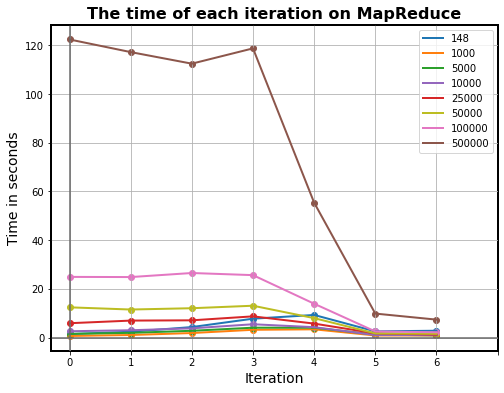

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
color_cycle = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red', 'tab:olive', 'tab:pink', 'tab:brown', 'tab:gray']

for i in range(len(nrows)):
    ax.plot(list(times_lvl[i].keys())[:-1], list(times_lvl[i].values())[:-1], c=color_cycle[i%len(color_cycle)], ls='-', lw=2, label=f'{nrows[i]}')
    ax.scatter(list(times_lvl[i].keys())[:-1], list(times_lvl[i].values())[:-1], c=color_cycle[i%len(color_cycle)])

ax.axhline(0, color='dimgrey')
ax.axvline(0, color='dimgrey')
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('2')
ax.set_title(f"The time of each iteration on MapReduce", fontsize = 16, fontweight='bold')
ax.set_xlabel("Iteration", fontsize = 14)
ax.set_ylabel("Time in seconds", fontsize = 14)
ax.set_xticks(list(range(0,8,1)))
# ax.set_yticks(range(0,35,5))
ax.grid()

plt.legend()
plt.show(fig)

# Spark

In [28]:
!pip install --quiet pyspark

In [29]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

In [35]:
from pyspark import SparkContext
# sc.stop()
sc = SparkContext(master = 'local')

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Python Spark SQL basic example").config("spark.some.config.option", "some-value").getOrCreate()

In [45]:
Spark = []

for i in nrows:
    data = spark.read.csv("/content/gdrive/MyDrive/BDP_data/lymph" + str(i)+ ".csv", header=True, inferSchema=True)

    index = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16]
    categorical_columns = [data.columns[i] for i in index]

    stringindexer_stages = [StringIndexer(inputCol=c, outputCol='strindexed_' + c) for c in categorical_columns]
    # encode label column and add it to stringindexer_stages
    stringindexer_stages += [StringIndexer(inputCol='class', outputCol='label')]

    onehotencoder_stages = [OneHotEncoder(inputCol='strindexed_' + c, outputCol='onehot_' + c) for c in categorical_columns]

    feature_columns = ['onehot_' + c for c in categorical_columns]
    vectorassembler_stage = VectorAssembler(inputCols=feature_columns, outputCol='features')

    all_stages = stringindexer_stages + onehotencoder_stages + [vectorassembler_stage]
    pipeline = Pipeline(stages=all_stages)

    pipeline_model = pipeline.fit(data)

    final_columns = feature_columns + ['features', 'label']
    data_df = pipeline_model.transform(data).select(final_columns)

    dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')

    start  = time.time()
    dtc = dt.fit(data_df)
    end = time.time()
    Spark.append(end-start)

In [46]:
print(Spark)

[1.1437757015228271, 1.099515438079834, 2.2797653675079346, 2.1041479110717773, 3.3937489986419678, 3.339796543121338, 5.535132646560669, 26.126930952072144]


In [47]:
print(dtc.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_554c0d0f704a, depth=5, numNodes=37, numClasses=4, numFeatures=29
  If (feature 15 in {0.0})
   If (feature 28 in {0.0})
    If (feature 16 in {0.0})
     If (feature 17 in {0.0})
      If (feature 1 in {0.0})
       Predict: 3.0
      Else (feature 1 not in {0.0})
       Predict: 2.0
     Else (feature 17 not in {0.0})
      If (feature 3 in {0.0})
       Predict: 1.0
      Else (feature 3 not in {0.0})
       Predict: 0.0
    Else (feature 16 not in {0.0})
     If (feature 21 in {0.0})
      Predict: 0.0
     Else (feature 21 not in {0.0})
      If (feature 0 in {0.0})
       Predict: 0.0
      Else (feature 0 not in {0.0})
       Predict: 1.0
   Else (feature 28 not in {0.0})
    If (feature 9 in {0.0})
     If (feature 1 in {0.0})
      Predict: 0.0
     Else (feature 1 not in {0.0})
      If (feature 6 in {0.0})
       Predict: 2.0
      Else (feature 6 not in {0.0})
       Predict: 1.0
    Else (feature 9 not in {0.0})
  

In [48]:
def parse_debug_string_lines(lines):
    block = []

    while lines:
        if lines[0].startswith('If'):
            bl = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
            block.append({'name': bl, 'children': parse_debug_string_lines(lines)})

            if lines[0].startswith('Else'):
                be = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
                block.append({'name': be, 'children': parse_debug_string_lines(lines)})

        elif not lines[0].startswith(('If', 'Else')):
            block2 = lines.pop(0)
            block.append({'name': block2})

        else:
            break

    return block

def debug_str_to_json(debug_string):
    data = []

    for line in debug_string.splitlines():
        if line.strip():
            line = line.strip()
            data.append(line)
        else:
            break
        if not line: 
            break

    json = {'name': 'Root', 'children': parse_debug_string_lines(data[1:])}
    return json

In [49]:
import json

dict_tree_json = debug_str_to_json(dtc.toDebugString)
print(json.dumps(dict_tree_json, indent = 1 ))

{
 "name": "Root",
 "children": [
  {
   "name": "feature 15 in {0.0}",
   "children": [
    {
     "name": "feature 28 in {0.0}",
     "children": [
      {
       "name": "feature 16 in {0.0}",
       "children": [
        {
         "name": "feature 17 in {0.0}",
         "children": [
          {
           "name": "feature 1 in {0.0}",
           "children": [
            {
             "name": "Predict: 3.0"
            }
           ]
          },
          {
           "name": "feature 1 not in {0.0}",
           "children": [
            {
             "name": "Predict: 2.0"
            }
           ]
          }
         ]
        },
        {
         "name": "feature 17 not in {0.0}",
         "children": [
          {
           "name": "feature 3 in {0.0}",
           "children": [
            {
             "name": "Predict: 1.0"
            }
           ]
          },
          {
           "name": "feature 3 not in {0.0}",
           "children": [
            {
        

# Comparison

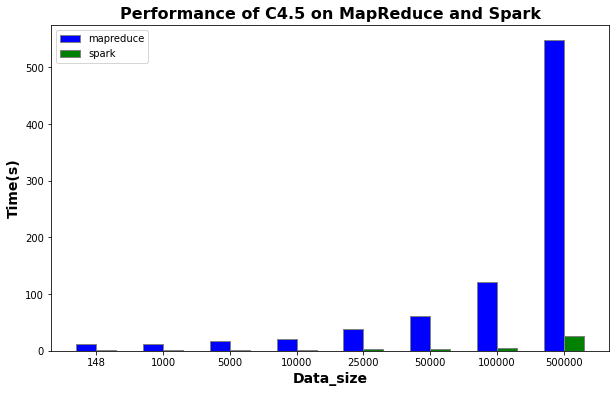

In [50]:
barWidth = 0.3
fig = plt.subplots(figsize = (10, 6))

br1 = np.arange(len(MR))
br2 = [x + barWidth for x in br1]

plt.bar(br1, MR, color ='b', width = barWidth,
		edgecolor ='grey', label ='mapreduce')
plt.bar(br2, Spark, color ='g', width = barWidth,
		edgecolor ='grey', label ='spark')

# Adding Xticks
plt.title('Performance of C4.5 on MapReduce and Spark', fontweight ='bold', fontsize = 16)
plt.xlabel('Data_size', fontweight ='bold', fontsize = 14)
plt.ylabel('Time(s)', fontweight ='bold', fontsize = 14)
plt.xticks([r + barWidth/2 for r in range(len(MR))],
		['148', '1000', '5000', '10000', '25000', '50000', '100000', '500000'])

plt.legend()
plt.show()

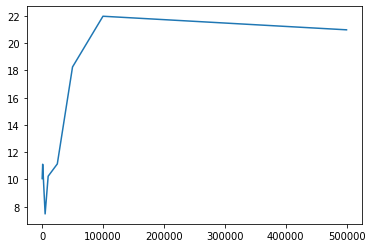

In [51]:
ratio = [MR[i]/Spark[i] for i in range(8)]
plt.plot(nrows, ratio)
plt.show()